# Carga de paquetes y datos fuente

In [1]:
#Importar paquetes necesarios
#Pandas
import pandas as pd
import numpy as np
#Seaborn visualizacion de datos
import seaborn as sns
import matplotlib.pyplot as plt
# Paquetes para seleccion de variables
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 # chi2 Estadísticas chi-cuadrado de características no negativas para tareas de clasificación.
#Paquete para separar muestras 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
#Paquete para crear el random forest
from sklearn.ensemble import RandomForestClassifier
#Paquete de metricas
from sklearn import metrics
#Paquete para balanceo de carga
from imblearn.over_sampling import SMOTE

Extracción de los datos <br>
Tomados desde -> https://www.kaggle.com/datasets/sanjanchaudhari/employees-performance-for-hr-analytics

In [23]:
dataemployees = pd.read_csv(r'C:\Users\juanm\Desktop\Provisional\Uncleaned_employees_final_dataset (1).csv')
dataemployees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17417 entries, 0 to 17416
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employee_id            17417 non-null  int64  
 1   department             17417 non-null  object 
 2   region                 17417 non-null  object 
 3   education              16646 non-null  object 
 4   gender                 17417 non-null  object 
 5   recruitment_channel    17417 non-null  object 
 6   no_of_trainings        17417 non-null  int64  
 7   age                    17417 non-null  int64  
 8   previous_year_rating   16054 non-null  float64
 9   length_of_service      17417 non-null  int64  
 10  KPIs_met_more_than_80  17417 non-null  int64  
 11  awards_won             17417 non-null  int64  
 12  avg_training_score     17417 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.7+ MB


# Exploración de los datos

<AxesSubplot:>

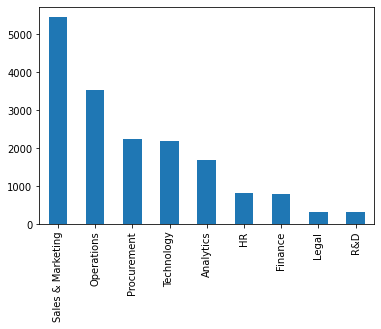

In [3]:
dataemployees.department.value_counts().plot(kind='bar')

<AxesSubplot:>

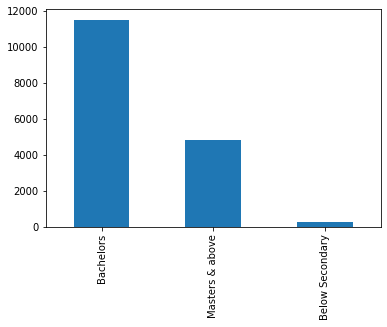

In [4]:
#Revision de region
dataemployees.education.value_counts().plot(kind='bar')

<AxesSubplot:>

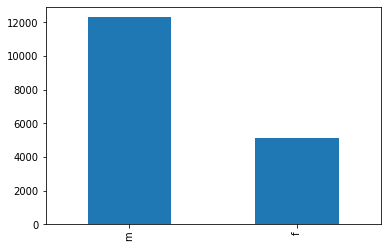

In [5]:
#Revision de genero
dataemployees.gender.value_counts().plot(kind='bar')

In [6]:
#Revision de numero de entrenamiento
analisisnot=dataemployees.no_of_trainings.value_counts().to_frame()
analisisnot['acumulado']=analisisnot.cumsum()
total=sum(analisisnot['no_of_trainings'])
analisisnot['porcentaje_acumulado']=analisisnot['acumulado']/total
analisisnot

,no_of_trainings,acumulado,porcentaje_acumulado
1,14061,14061,0.807315
2,2628,16689,0.958202
3,539,17228,0.989149
4,137,17365,0.997014
5,26,17391,0.998507
6,16,17407,0.999426
7,6,17413,0.999770
8,2,17415,0.999885
9,2,17417,1.000000


Puede observarse que ha medida que aumentan el numero de entrenamientos, la cantidad de datos disminuye, ahora se compara con la variable de interes

In [7]:
dataemployees.pivot_table(values='employee_id',index='no_of_trainings',columns='KPIs_met_more_than_80',aggfunc='size',fill_value=0)

KPIs_met_more_than_80,0,1
no_of_trainings,,
1,8891,5170
2,1752,876
3,374,165
4,109,28
5,18,8
6,16,0
7,5,1
8,1,1
9,1,1


Dado que la cantidad de datos desde los 6 entrenamientos es poco significativa comparado con la variable de intereses, se eliminan estos registros considerandolos outliers.

In [8]:
dataemployees.age.describe()

count    17417.000000
mean        34.807774
std          7.694046
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64

la cantidad de registros vacios en esta columna es: 1363


<AxesSubplot:xlabel='previous_year_rating', ylabel='Count'>

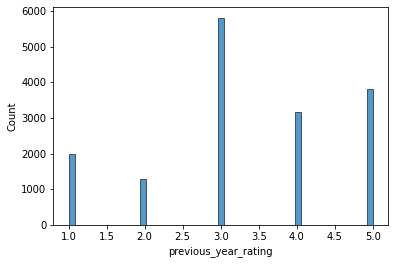

In [9]:
#Revision del puntaje del año anterior
print(f"la cantidad de registros vacios en esta columna es: {dataemployees.previous_year_rating.isnull().sum()}")
sns.histplot(dataemployees.previous_year_rating)

Dado que la columna de puntaje del año anterior tiene mas de 1000 registros vacios, se valida su conexion con otras variables, principalmente con la antiguedad.

In [10]:
analisispyr=dataemployees.copy()
analisispyr.previous_year_rating.fillna(0,inplace=True)
analisispyr.pivot_table(values='employee_id',index='length_of_service',columns='previous_year_rating',aggfunc='size').head()

previous_year_rating,0.0,1.0,2.0,3.0,4.0,5.0
length_of_service,,,,,,
1,1363.0,15.0,11.0,54.0,31.0,24.0
2,NaN,266.0,175.0,761.0,389.0,503.0
3,NaN,290.0,175.0,803.0,463.0,518.0
4,NaN,272.0,169.0,788.0,424.0,509.0
5,NaN,240.0,180.0,654.0,397.0,443.0


De este analisis puede destacarse que todos los empleados que no tienen una puntuacion del año anterior son empleados con una antiguedad de 1 periodo, por esta razon se reemplazaran estos valores con el promedio de este grupo.

<AxesSubplot:xlabel='KPIs_met_more_than_80', ylabel='Count'>

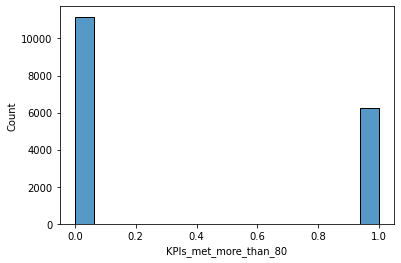

In [11]:
#Revision de KPI
sns.histplot(data=dataemployees.KPIs_met_more_than_80)

De este grafico puede destacarse que la variable de interes esta desbalanceada, pues los registros con etiqueta 0 son aproximadamente el doble de los registros con la etiqueta 1. Por esta razon se balanceara los datos del modelo para no afectar su desempeño.

# Implementación del modelo

Se ajusta los datos de acuerdo a las reglas previamente establecida en la exploración de los datos

In [12]:
#Lectura de los datos
dataemployees = pd.read_csv(r'C:\Users\juanm\Desktop\Provisional\Uncleaned_employees_final_dataset (1).csv')
#Relleno de valores vacios
valorrelleno= round(dataemployees.query("length_of_service==1 and previous_year_rating>0").previous_year_rating.mean(),0)
dataemployees.previous_year_rating.fillna(valorrelleno,inplace=True)
dataemployees.education.fillna('unknown',inplace=True)
#Eliminacion de outliers
dataemployees=dataemployees[dataemployees.no_of_trainings<=5]
dataemployees=dataemployees[dataemployees.length_of_service<=20]
dataemployees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17254 entries, 0 to 17416
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employee_id            17254 non-null  int64  
 1   department             17254 non-null  object 
 2   region                 17254 non-null  object 
 3   education              17254 non-null  object 
 4   gender                 17254 non-null  object 
 5   recruitment_channel    17254 non-null  object 
 6   no_of_trainings        17254 non-null  int64  
 7   age                    17254 non-null  int64  
 8   previous_year_rating   17254 non-null  float64
 9   length_of_service      17254 non-null  int64  
 10  KPIs_met_more_than_80  17254 non-null  int64  
 11  awards_won             17254 non-null  int64  
 12  avg_training_score     17254 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.8+ MB


Dado que existen variables categorias se crean variables dummy que son usadas por los modelos de machine learning.

In [13]:
#Agregar columnas dummies para variables categoricas
dataemployees=pd.get_dummies(data=dataemployees,columns=['department','education','gender','recruitment_channel',],drop_first=True)
dataemployees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17254 entries, 0 to 17416
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   employee_id                   17254 non-null  int64  
 1   region                        17254 non-null  object 
 2   no_of_trainings               17254 non-null  int64  
 3   age                           17254 non-null  int64  
 4   previous_year_rating          17254 non-null  float64
 5   length_of_service             17254 non-null  int64  
 6   KPIs_met_more_than_80         17254 non-null  int64  
 7   awards_won                    17254 non-null  int64  
 8   avg_training_score            17254 non-null  int64  
 9   department_Finance            17254 non-null  uint8  
 10  department_HR                 17254 non-null  uint8  
 11  department_Legal              17254 non-null  uint8  
 12  department_Operations         17254 non-null  uint8  
 13  d

Se crean dataframes de las variables explicativas y la variable de interes

In [14]:
#Crear las variables con todo el dataframe
X_unbalanced=dataemployees[['no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'awards_won',
       'avg_training_score', 'department_Finance',
       'department_HR', 'department_Legal', 'department_Operations',
       'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'education_Below Secondary', 'education_Masters & above', 'gender_m',
       'recruitment_channel_referred', 'recruitment_channel_sourcing']]
y_unbalanced=dataemployees['KPIs_met_more_than_80']

Se balancea la muestra con la técnica de oversampling, creando mas registros para la categoria 0

In [15]:
# 3. Muestra Desbalanceada con Oversampling
oversampler = SMOTE(sampling_strategy='minority')
X, y = oversampler.fit_resample(X_unbalanced, y_unbalanced)

Se seleccionan las variables explicativas que tiene una mejor relacion con la variable de interes, de acuerdo a un experimiento previo se identifico que con 13 variables se obtiene el mejor modelo

In [16]:
cantidadVariables=13
seleccion = SelectKBest(score_func=chi2, k=cantidadVariables)
seleccion.fit_transform(X,y)
#La lista filtro indica cuales variables son las recomendadas
filtro = seleccion.get_support()
#Script para seleccionar las variables mas importantes
columnasOriginales=np.array(X.columns)
MejoresVariables=list(columnasOriginales[filtro])
print(MejoresVariables)
#Se ajusta X
X=X[MejoresVariables]
X.head(5)

['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won', 'avg_training_score', 'department_HR', 'department_Legal', 'department_Operations', 'department_Sales & Marketing', 'education_Masters & above', 'gender_m', 'recruitment_channel_sourcing']


,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_HR,department_Legal,department_Operations,department_Sales & Marketing,education_Masters & above,gender_m,recruitment_channel_sourcing
0,1,24,3.0,1,0,77,0,0,0,0,0,1,1
1,1,31,3.0,5,0,51,1,0,0,0,0,0,0
2,1,31,1.0,4,0,47,0,0,0,1,0,1,0
3,3,31,2.0,9,0,65,0,0,0,0,0,0,0
4,1,30,4.0,7,0,61,0,0,0,0,0,1,1


# Creación del modelo

Se utilizan hiperparametros y un objeto GridSearchCV para crear el mejor modelo

In [17]:
#Creación de los hiperparametros
hyperparameters = {
    'n_estimators': [5,10,20],  # Número de árboles
    'max_depth': [5, 10, 15],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 4, 6]  # Número mínimo de muestras necesarias para dividir un nodo
}
# Se crea la instancia del clasificador
modeloRFCInicial = RandomForestClassifier()
# Creamos un objeto GridSearchCV
grid_cv = GridSearchCV(estimator=modeloRFCInicial,
                       param_grid=hyperparameters,
                       scoring=make_scorer(accuracy_score),
                       cv=5)
# Separar los datos en entrenamientos y evaluacion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Entrenamos el GridSearchCV con los datos de entrenamiento
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [5, 10, 20]},
             scoring=make_scorer(accuracy_score))

In [18]:
# Obtenemos el mejor modelo y lo asignamos a la variable modeloRFC
modeloRFC = grid_cv.best_estimator_
# Identificar los resultados de la validacion cruzada y mejores hiperparametros
best_params = grid_cv.best_params_
best_score = grid_cv.best_score_
print(f"El mejor conjunto de hiperparámetros es: {best_params}")
print(f"La mejor puntuación de validación cruzada obtenida fue: {best_score}")

El mejor conjunto de hiperparámetros es: {'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 20}
La mejor puntuación de validación cruzada obtenida fue: 0.7226649945887956


# Medición del modelo

In [19]:
# Realizamos las predicciones con los datos del X_test
y_pred_rfc = modeloRFC.predict(X_test)

In [20]:
#Validar metricas del modelo
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_rfc) :.2%}")
print(f"Precision: {metrics.precision_score(y_test, y_pred_rfc) :.2%}")
print(f"Recall: {metrics.recall_score(y_test, y_pred_rfc) :.2%}")
print("--Reporte de clasificación--")
print(metrics.classification_report(y_test, y_pred_rfc, digits=3))

Accuracy: 72.15%
Precision: 72.90%
Recall: 70.16%
--Reporte de clasificación--
              precision    recall  f1-score   support

           0      0.715     0.741     0.728      3323
           1      0.729     0.702     0.715      3298

    accuracy                          0.721      6621
   macro avg      0.722     0.721     0.721      6621
weighted avg      0.722     0.721     0.721      6621



De acuerdo a estas metricas 72 de cada 100 predicciones seran correctas, en el 73% de los casos el modelo no etiquetara erroneamente los datos y en el 70% de los casos encontrara todas las muestras positivas

# Analisis del modelo

Aunque puede implementarse el modelo, se sugiere seguir explorando variables de negocio y recopilar información de otras variables para crear modelos con mejores estadisticas de rendimiento.